# Wstęp do uczenia maszynowego - PD1

## 1. Eksploracyjna analiza danych
W pierszej kolejności przyjrzyjmy się danym, na których później będziemy modelować.

In [32]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     KFold)
from sklearn.tree import DecisionTreeClassifier

sns.set(style='darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading data
X = pd.read_csv('X.csv', index_col=0)
y = pd.read_csv('y.csv', index_col=0)
y.columns = ['target']

# Combining data into one data frame for easier exploration
df = pd.concat([X, y], axis=1)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,target
0,2.504280,1.165802,2.567506,-0.399940,1.008110,2.379108,0.991698,0.563444,0.0
1,-2.201358,0.887550,0.872891,2.023147,-1.711817,-1.637994,1.143967,-0.743122,0.0
2,2.233496,0.464743,3.470472,-1.888077,-2.610473,0.301459,1.742215,1.515108,0.0
3,-1.311672,-0.768893,-2.615540,-1.522393,0.381070,-1.245576,-1.837726,1.617176,1.0
4,-0.562231,1.267943,1.603228,1.166734,-0.399512,-0.091997,1.149495,1.031725,0.0


In [4]:
df.describe()

,0,1,2,3,4,5,6,7,target
count,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,946.000000
mean,-0.016634,0.009323,0.394778,0.541488,-0.995397,0.091138,-0.014405,-0.067722,0.497886
std,1.550788,1.485657,2.274194,1.689062,1.430075,1.917017,1.651510,1.017954,0.500260
min,-5.634847,-4.491813,-6.399191,-3.807665,-7.573028,-4.938971,-5.370469,-5.188007,0.000000
25%,-1.080786,-1.068714,-1.237993,-0.712260,-1.954813,-1.302972,-1.027901,-0.730426,0.000000
50%,0.127341,-0.122176,0.397683,0.657789,-0.970469,0.046226,0.290657,-0.078105,0.000000
75%,1.143570,1.077955,2.122202,1.617422,-0.003298,1.425184,1.144729,0.627713,1.000000
max,7.304825,5.482399,16.040589,5.528257,3.110177,5.591951,8.349125,3.232800,1.000000


Widzimy, że wszystkie zmienne są numeryczne i ciągłe.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 949 entries, 0 to 948
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       949 non-null    float64
 1   1       949 non-null    float64
 2   2       949 non-null    float64
 3   3       949 non-null    float64
 4   4       949 non-null    float64
 5   5       949 non-null    float64
 6   6       949 non-null    float64
 7   7       949 non-null    float64
 8   target  946 non-null    float64
dtypes: float64(9)
memory usage: 74.1 KB


Widzimy, że w zmiennej celu mamy 3 brakujące wartości, najprawdopodobniej usuniemy te wiersze z danych. Sprawdźmy teraz jej rozkład.

Text(0, 0.5, 'Count')

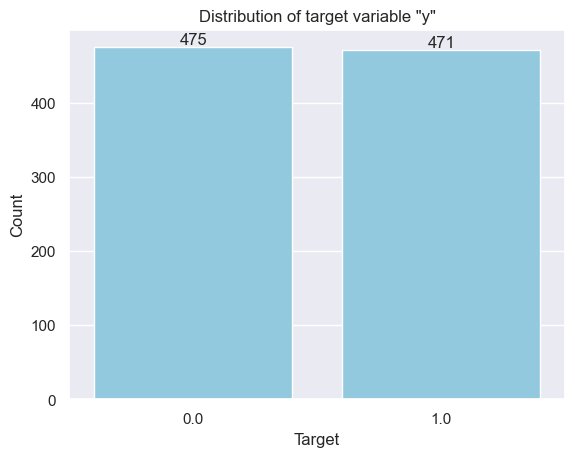

In [6]:
ax = sns.countplot(data=df, x='target', color='skyblue')
ax.bar_label(ax.containers[0])
ax.set_title('Distribution of target variable "y"')
ax.set_xlabel('Target')
ax.set_ylabel('Count')

Widzimy, że nasz zbiór jest praktycznie perfekcyjnie zbalansowany, co jest świetną informacją przed modelowaniem.

Przyjrzyjmy się teraz rozkładom pozostałych zmiennych.

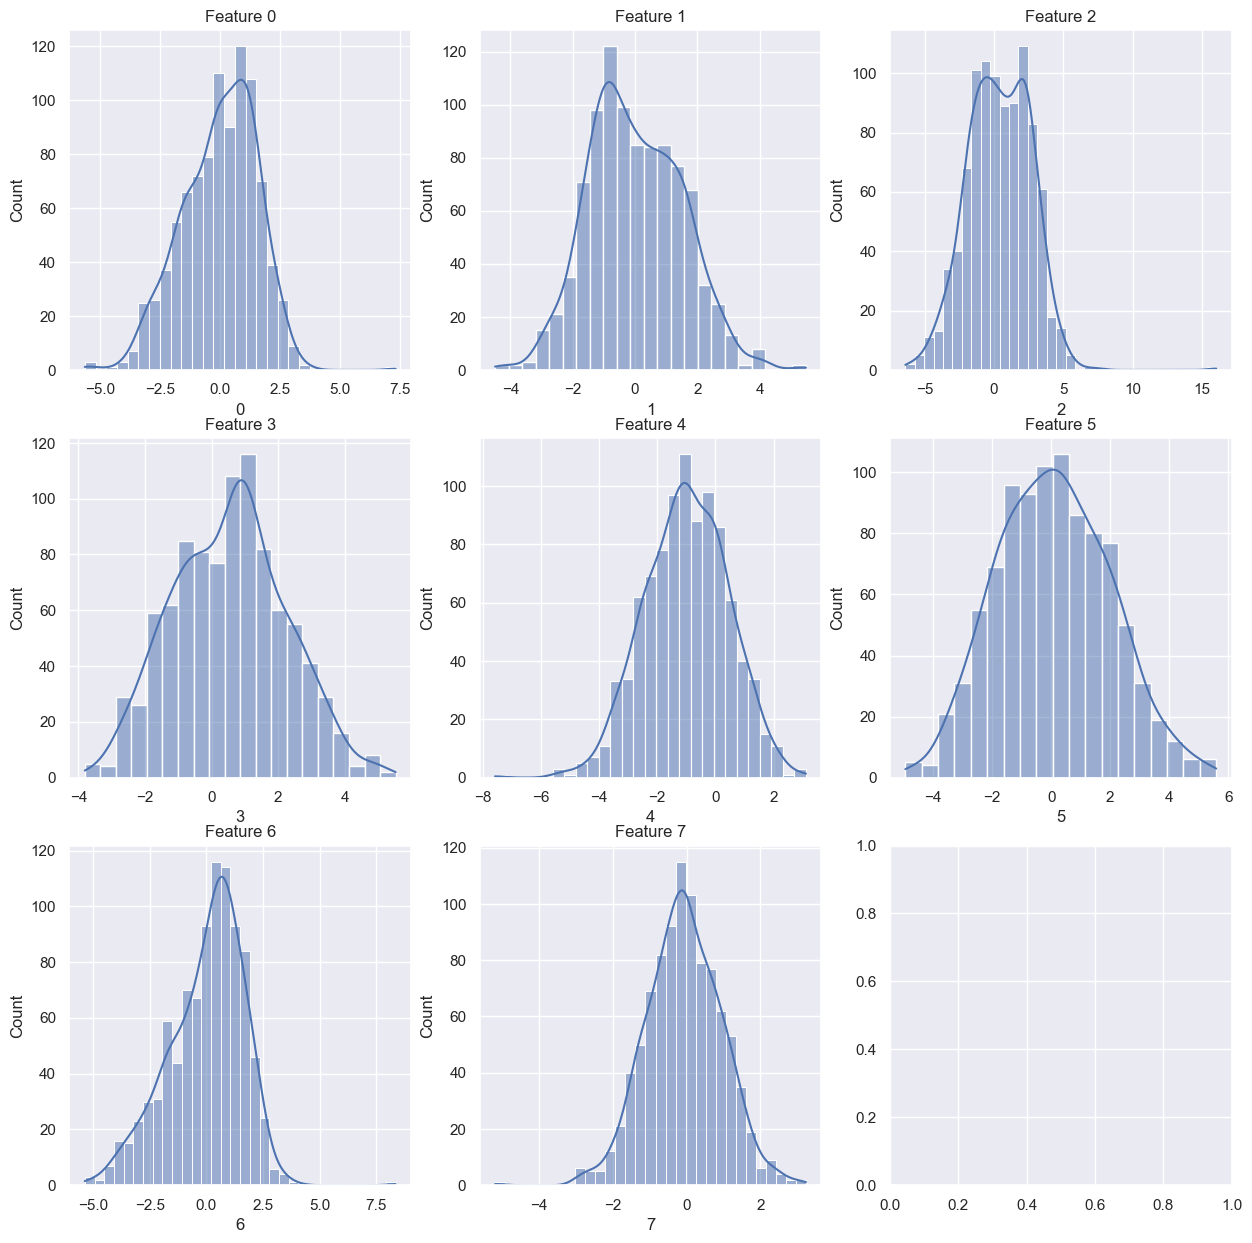

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(8):
    sns.histplot(data=df, x=df.columns[i], ax=ax[i//3, i%3], kde=True)
    ax[i//3, i%3].set_title(f'Feature {df.columns[i]}')

Sprawdźmy też korelacje między zmiennymi, oraz czy zmienna celu ma na nią wpływ.

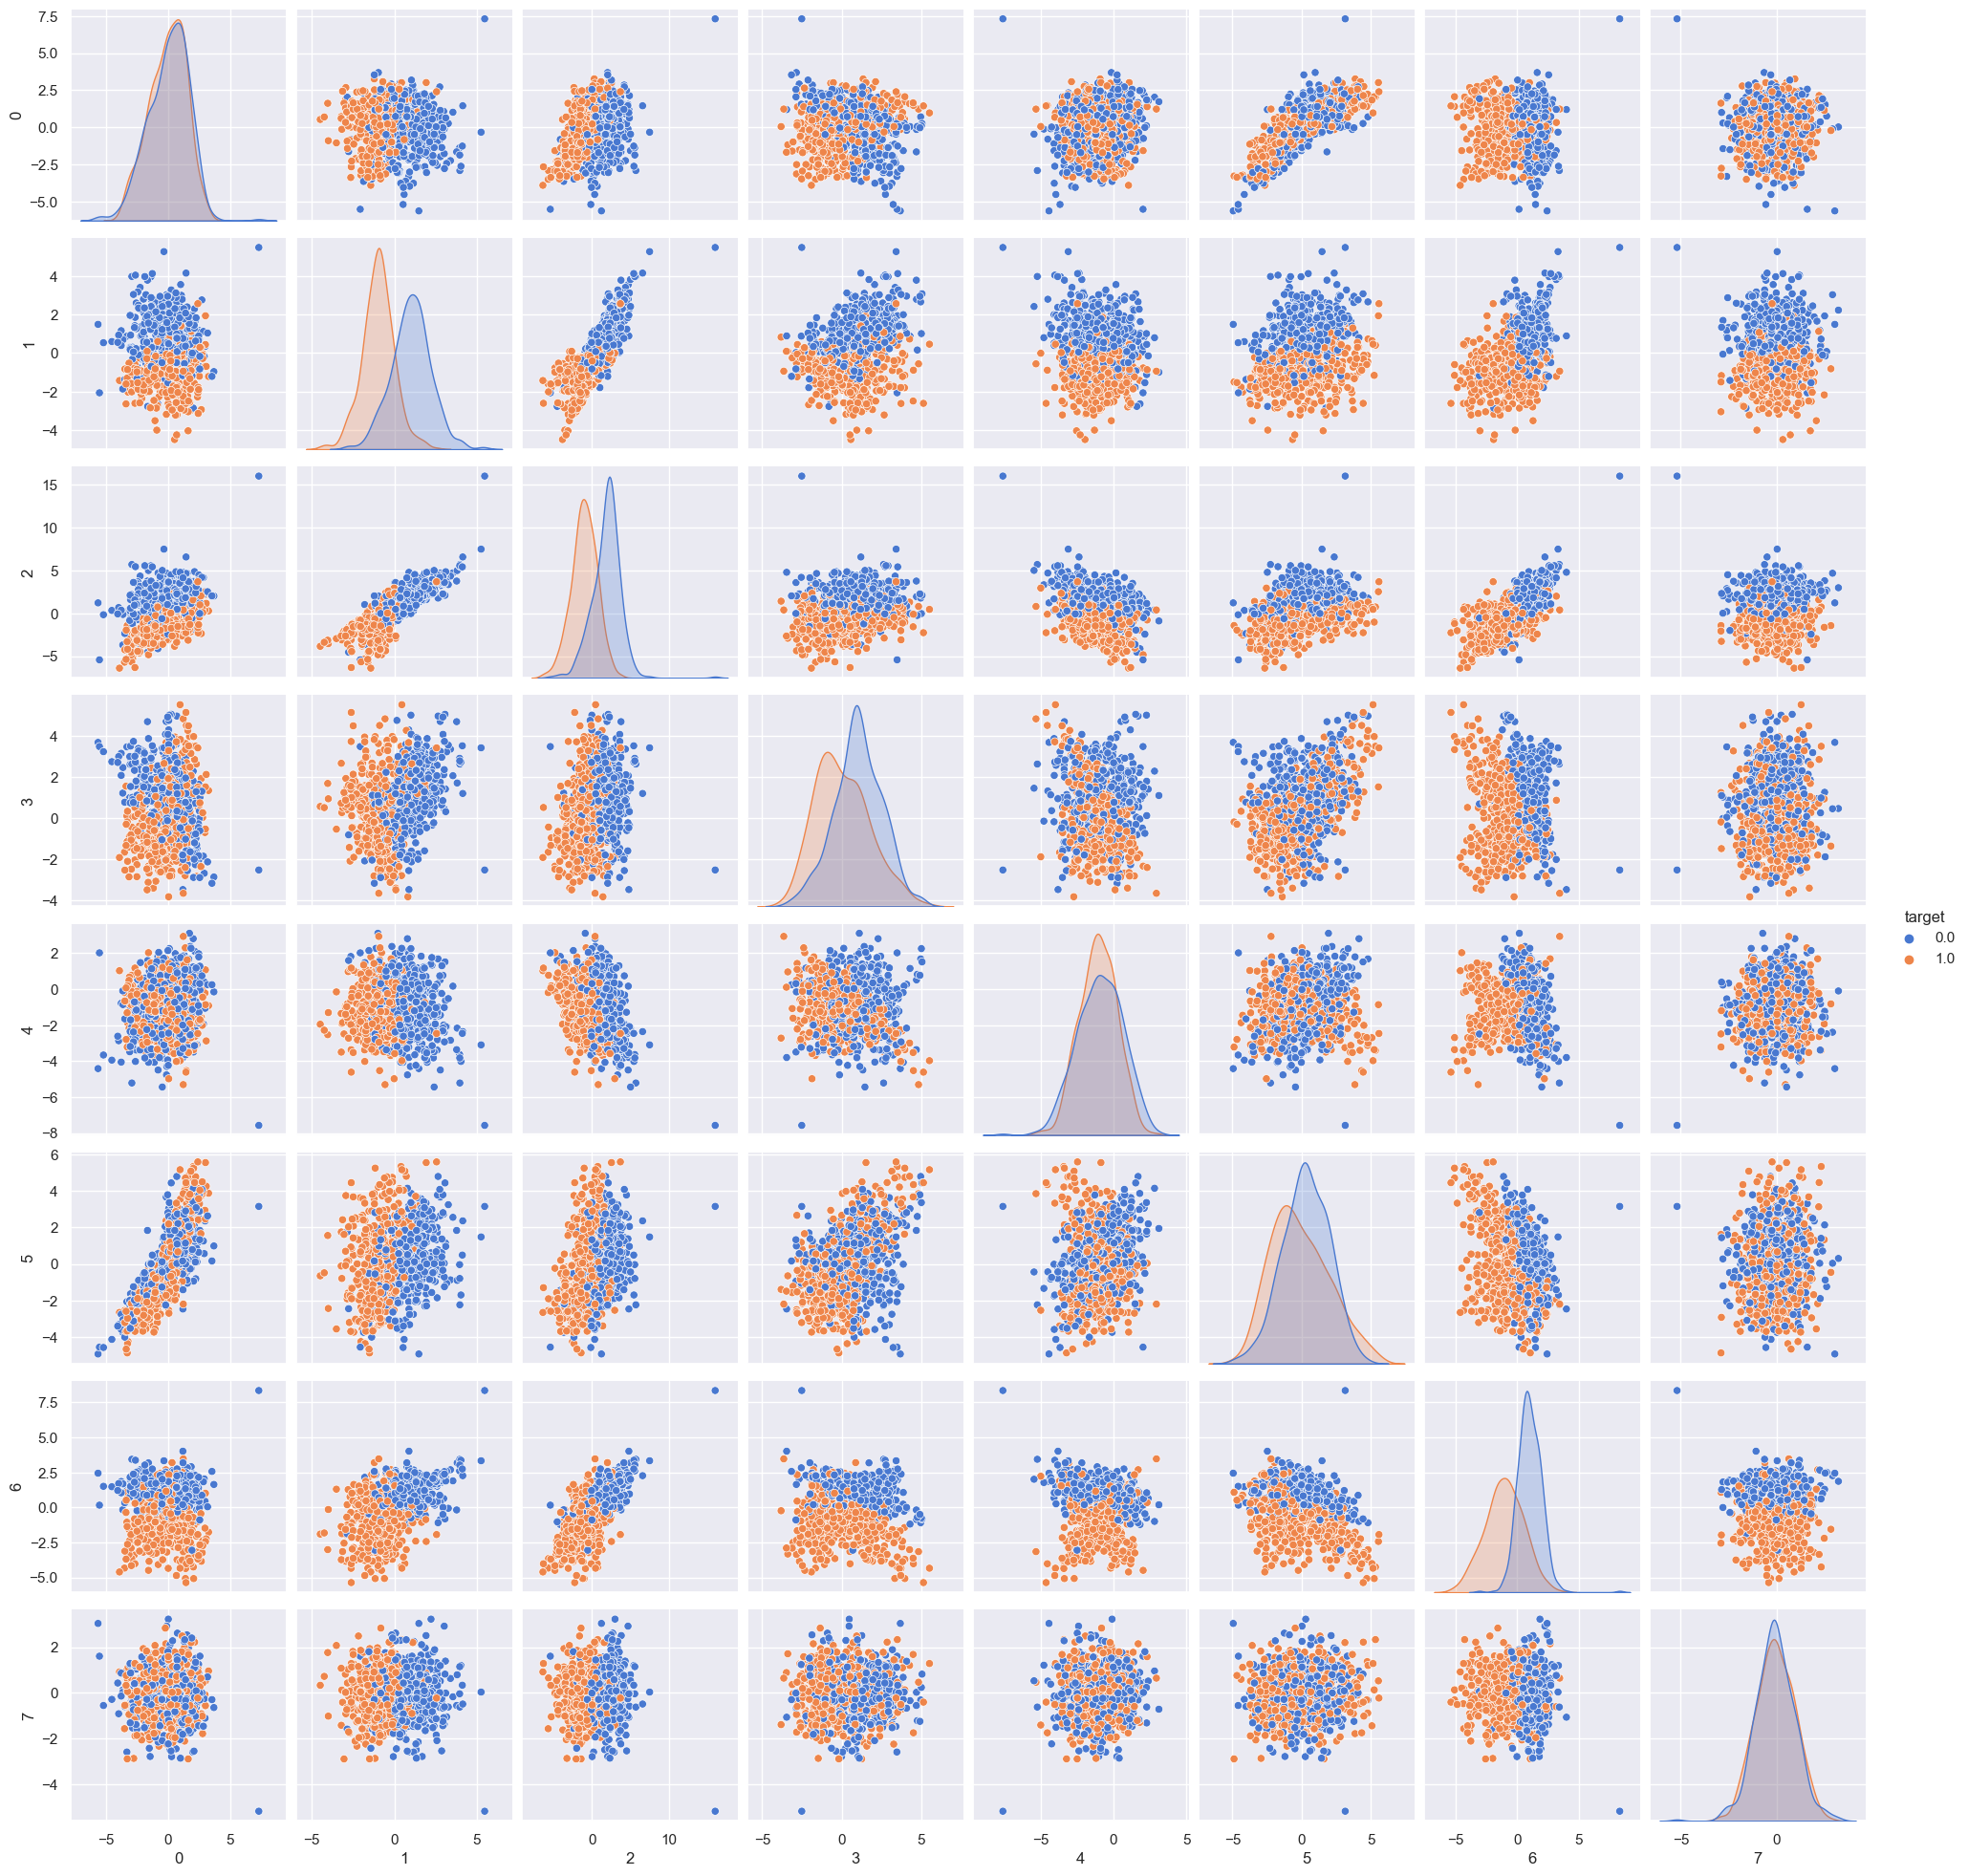

In [8]:
sns.pairplot(df, hue='target', palette='muted')

Możemy zauważyć, że niektóre zmienne bardzo dobrze rozdzielają obserwacje z różnych klas, a inne nie mają tak dużego wpływu.

## 2. Przygotowanie danych

In [24]:
# Get index of missing values
missing = y[y.isnull().any(axis=1)].index

# Drop missing values
X = X.drop(missing)
y = y.drop(missing)

# Check if missing values are dropped
X.shape, y.shape, X.isnull().sum().sum(), y.isnull().sum().sum()

((946, 8), (946, 1), 0, 0)

In [25]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=327217)

## 3. Eksperyment

In [35]:
cv = KFold(n_splits=5, shuffle=True, random_state=327217)
scoring = 'roc_auc'

criterion = ['gini', 'entropy']
max_depth = range(3, 10)
min_samples_leaf = range(1, 8)

results = pd.DataFrame(columns=['Criterion', 'Depth', 'Leaf', 'AUC Score train (mean)', 'AUC Score test'])

for crit in criterion:
    for depth in max_depth:
        for leaf in min_samples_leaf:
            model = DecisionTreeClassifier(criterion=crit, max_depth=depth,
                                           min_samples_leaf=leaf)
            